# Custom Parameters

In [1]:
#Assign these values as per your requirements.
global min_qubits,max_qubits,skip_qubits,max_circuits,num_shots,Noise_Inclusion

min_qubits=3
max_qubits=5
skip_qubits=1
num_shots=1000
Noise_Inclusion = False
saveplots = False

Memory_utilization_plot = True
gate_counts_plots = True
Store_Data = True
save_to_excel = True

# Imports:

In [2]:
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, BasicAer
from qiskit import *
import time
import matplotlib.pyplot as plt

benchmark_name = "Deutsch-Jozsa"


# Selection of basis gate set for transpilation
# Note: selector 1 is a hardware agnostic gate set
basis_selector = 1
basis_gates_array = [
    [],
    ['rx', 'ry', 'rz', 'cx'],       # a common basis set, default
    ['cx', 'rz', 'sx', 'x'],        # IBM default basis set
    ['rx', 'ry', 'rxx'],            # IonQ default basis set
    ['h', 'p', 'cx'],               # another common basis set
    ['u', 'cx']                     # general unitaries basis gates
]

np.random.seed(0)

# Declaring Backend :

In [3]:
backend = BasicAer.get_backend('dm_simulator') #Using dm_simulator as backend for our execution
QV_ = None
platform = backend.name()

# Algorithm :

In [4]:
# saved circuits for display
QC_ = None
C_ORACLE_ = None
B_ORACLE_ = None

def constant_oracle (input_size, num_qubits):
    
    #Initialize first n qubits and single ancilla qubit
    qc = QuantumCircuit(num_qubits, name=f"Uf")

    output = np.random.randint(2)
    
    if output == 1:
        qc.x(input_size)

    global C_ORACLE_
    if C_ORACLE_ == None or num_qubits <= 6:
        if num_qubits < 9: C_ORACLE_ = qc
            
    return qc

In [5]:
def balanced_oracle (input_size, num_qubits):
    #Initialize first n qubits and single ancilla qubit
    qc = QuantumCircuit(num_qubits, name=f"Uf")

    b_str = "101010101010101010101010101010101"              # permit input_string up to 20 chars
    for qubit in range(input_size):
        if b_str[qubit] == '1':
            qc.x(qubit)

    qc.barrier()

    for qubit in range(input_size):
        qc.cx(qubit, input_size)

    qc.barrier()

    for qubit in range(input_size):
        if b_str[qubit] == '1':
            qc.x(qubit)

    global B_ORACLE_
    if B_ORACLE_ == None or num_qubits <= 6:
        if num_qubits < 9: B_ORACLE_ = qc
            
    return qc

In [6]:
def DeutschJozsa (num_qubits, type):
    
    # Size of input is one less than available qubits
    input_size = num_qubits - 1

    # allocate qubits
    qr = QuantumRegister(num_qubits); cr = ClassicalRegister(input_size);
    qc = QuantumCircuit(qr, cr, name=f"dj-{num_qubits}-{type}")

    for qubit in range(input_size):
        qc.h(qubit)
    qc.x(input_size)
    qc.h(input_size)
    
    qc.barrier()
    
    # Add a constant or balanced oracle function
    if type == 0: Uf = constant_oracle(input_size, num_qubits)
    else: Uf = balanced_oracle(input_size, num_qubits)
    qc.append(Uf, qr)

    qc.barrier()
    
    for qubit in range(num_qubits):
        qc.h(qubit)
    
    # uncompute ancilla qubit, not necessary for algorithm
    qc.x(input_size)
    
    qc.barrier()
    
    for i in range(input_size):
        qc.measure(i, i)
    
    # save smaller circuit and oracle subcircuit example for display
    global QC_
    if QC_ == None or num_qubits <= 6:
        if num_qubits < 9: QC_ = qc

    # return a handle to the circuit
    return qc

# Noise Parameters :

In [7]:
# Noise parameters
options = { } #if Noise is None

options_noisy = { #if Noise is not None
    'plot': False,
    "thermal_factor": 0.9,
    'show_partition': False,
    "decoherence_factor": 0.9,
    "depolarization_factor": 0.9,
    "bell_depolarization_factor": 1,
    "decay_factor": 0.75,
    "rotation_error": {'rx':[1.0, 0.0], 'ry':[1.0, 0.0], 'rz':[1.0, 0.0]},
    "tsp_model_error": [1.0, 0.0],
}

# Fidelity Calculations :

In [8]:
## Uniform distribution function commonly used
def rescale_fidelity(fidelity, floor_fidelity, new_floor_fidelity):
    """
    Linearly rescales our fidelities to allow comparisons of fidelities across benchmarks
    
    fidelity: raw fidelity to rescale
    floor_fidelity: threshold fidelity which is equivalent to random guessing
    new_floor_fidelity: what we rescale the floor_fidelity to 

    Ex, with floor_fidelity = 0.25, new_floor_fidelity = 0.0:
        1 -> 1;
        0.25 -> 0;
        0.5 -> 0.3333;
    """
    rescaled_fidelity = (1-new_floor_fidelity)/(1-floor_fidelity) * (fidelity - 1) + 1
    
    # ensure fidelity is within bounds (0, 1)
    if rescaled_fidelity < 0:
        rescaled_fidelity = 0.0
    if rescaled_fidelity > 1:
        rescaled_fidelity = 1.0
    
    return rescaled_fidelity

In [9]:
def uniform_dist(num_state_qubits):
    dist = {}
    for i in range(2**num_state_qubits):
        key = bin(i)[2:].zfill(num_state_qubits)
        dist[key] = 1/(2**num_state_qubits)
    return dist

In [10]:
### Analysis methods to be expanded and eventually compiled into a separate analysis.py file
import math, functools

def hellinger_fidelity_with_expected(p, q):
    """ p: result distribution, may be passed as a counts distribution
        q: the expected distribution to be compared against

    References:
        `Hellinger Distance @ wikipedia <https://en.wikipedia.org/wiki/Hellinger_distance>`_
        Qiskit Hellinger Fidelity Function
    """
    p_sum = sum(p.values())
    q_sum = sum(q.values())

    if q_sum == 0:
        print("ERROR: polarization_fidelity(), expected distribution is invalid, all counts equal to 0")
        return 0

    p_normed = {}
    for key, val in p.items():
        p_normed[key] = val/p_sum
        # if p_sum != 0:
        #     p_normed[key] = val/p_sum
        # else:
        #     p_normed[key] = 0

    q_normed = {}
    for key, val in q.items():
        q_normed[key] = val/q_sum

    total = 0
    for key, val in p_normed.items():
        if key in q_normed.keys():
            total += (np.sqrt(val) - np.sqrt(q_normed[key]))**2
            del q_normed[key]
        else:
            total += val
    total += sum(q_normed.values())
    
    # in some situations (error mitigation) this can go negative, use abs value
    if total < 0:
        print(f"WARNING: using absolute value in fidelity calculation")
        total = abs(total)
        
    dist = np.sqrt(total)/np.sqrt(2)
    fidelity = (1-dist**2)**2

    return fidelity


In [11]:
def polarization_fidelity(counts, correct_dist, thermal_dist=None):
    """
    Combines Hellinger fidelity and polarization rescaling into fidelity calculation
    used in every benchmark

    counts: the measurement outcomes after `num_shots` algorithm runs
    correct_dist: the distribution we expect to get for the algorithm running perfectly
    thermal_dist: optional distribution to pass in distribution from a uniform
                  superposition over all states. If `None`: generated as 
                  `uniform_dist` with the same qubits as in `counts`
                  
    returns both polarization fidelity and the hellinger fidelity

    Polarization from: `https://arxiv.org/abs/2008.11294v1`
    """
    num_measured_qubits = len(list(correct_dist.keys())[0])
    #print(num_measured_qubits)
    
    counts = {k.zfill(num_measured_qubits): v for k, v in counts.items()}
    
    # calculate hellinger fidelity between measured expectation values and correct distribution
    hf_fidelity = hellinger_fidelity_with_expected(counts,correct_dist)
    
    # to limit cpu and memory utilization, skip noise correction if more than 16 measured qubits
    if num_measured_qubits > 16:
        return { 'fidelity':hf_fidelity, 'hf_fidelity':hf_fidelity }

    # if not provided, generate thermal dist based on number of qubits
    if thermal_dist == None:
        thermal_dist = uniform_dist(num_measured_qubits)

    # set our fidelity rescaling value as the hellinger fidelity for a depolarized state
    floor_fidelity = hellinger_fidelity_with_expected(thermal_dist, correct_dist)

    # rescale fidelity result so uniform superposition (random guessing) returns fidelity
    # rescaled to 0 to provide a better measure of success of the algorithm (polarization)
    new_floor_fidelity = 0
    fidelity = rescale_fidelity(hf_fidelity, floor_fidelity, new_floor_fidelity)

    return { 'fidelity':fidelity, 'hf_fidelity':hf_fidelity }

# Functions of Volumetric Plots :

In [12]:
from matplotlib.patches import Rectangle
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize
from matplotlib.patches import Circle

############### Color Map functions
 
# Create a selection of colormaps from which to choose; default to custom_spectral
cmap_spectral = plt.get_cmap('Spectral')
cmap_greys = plt.get_cmap('Greys')
cmap_blues = plt.get_cmap('Blues')
cmap_custom_spectral = None

# the default colormap is the spectral map
cmap = cmap_spectral
cmap_orig = cmap_spectral

# current cmap normalization function (default None)
cmap_norm = None

default_fade_low_fidelity_level = 0.16
default_fade_rate = 0.7


# Specify a normalization function here (default None)
def set_custom_cmap_norm(vmin, vmax):

    global cmap_norm
    
    if vmin == vmax or (vmin == 0.0 and vmax == 1.0):
        print("... setting cmap norm to None")
        cmap_norm = None
    else:
        print(f"... setting cmap norm to [{vmin}, {vmax}]")
        cmap_norm = Normalize(vmin=vmin, vmax=vmax)
    
# Remake the custom spectral colormap with user settings
def set_custom_cmap_style(
            fade_low_fidelity_level=default_fade_low_fidelity_level,
            fade_rate=default_fade_rate):
            
    #print("... set custom map style")
    global cmap, cmap_custom_spectral, cmap_orig
    cmap_custom_spectral = create_custom_spectral_cmap(
                fade_low_fidelity_level=fade_low_fidelity_level, fade_rate=fade_rate)
    cmap = cmap_custom_spectral
    cmap_orig = cmap_custom_spectral


# Create the custom spectral colormap from the base spectral
def create_custom_spectral_cmap(
            fade_low_fidelity_level=default_fade_low_fidelity_level,
            fade_rate=default_fade_rate):

    # determine the breakpoint from the fade level
    num_colors = 100
    breakpoint = round(fade_low_fidelity_level * num_colors)
    
    # get color list for spectral map
    spectral_colors = [cmap_spectral(v/num_colors) for v in range(num_colors)]

    #print(fade_rate)
    
    # create a list of colors to replace those below the breakpoint
    # and fill with "faded" color entries (in reverse)
    low_colors = [0] * breakpoint
    #for i in reversed(range(breakpoint)):
    for i in range(breakpoint):
    
        # x is index of low colors, normalized 0 -> 1
        x = i / breakpoint
    
        # get color at this index
        bc = spectral_colors[i]
        r0 = bc[0]
        g0 = bc[1]
        b0 = bc[2]
        z0 = bc[3]
        
        r_delta = 0.92 - r0
        
        #print(f"{x} {bc} {r_delta}")
         
        # compute saturation and greyness ratio
        sat_ratio = 1 - x
        
        #grey_ratio = 1 - x
        '''  attempt at a reflective gradient   
        if i >= breakpoint/2:
            xf = 2*(x - 0.5)
            yf = pow(xf, 1/fade_rate)/2
            grey_ratio = 1 - (yf + 0.5)
        else:
            xf = 2*(0.5 - x)
            yf = pow(xf, 1/fade_rate)/2
            grey_ratio = 1 - (0.5 - yf)
        '''   
        grey_ratio = 1 - math.pow(x, 1/fade_rate)
        
        #print(f"  {xf} {yf} ")
        #print(f"  {sat_ratio} {grey_ratio}")

        r = r0 + r_delta * sat_ratio
        
        g_delta = r - g0
        b_delta = r - b0
        g = g0 + g_delta * grey_ratio
        b = b0 + b_delta * grey_ratio 
            
        #print(f"{r} {g} {b}\n")    
        low_colors[i] = (r,g,b,z0)
        
    #print(low_colors)

    # combine the faded low colors with the regular spectral cmap to make a custom version
    cmap_custom_spectral = ListedColormap(low_colors + spectral_colors[breakpoint:])

    #spectral_colors = [cmap_custom_spectral(v/10) for v in range(10)]
    #for i in range(10): print(spectral_colors[i])
    #print("")
    
    return cmap_custom_spectral

# Make the custom spectral color map the default on module init
set_custom_cmap_style()

# Arrange the stored annotations optimally and add to plot 
def anno_volumetric_data(ax, depth_base=2, label='Depth',
        labelpos=(0.2, 0.7), labelrot=0, type=1, fill=True):
    
    # sort all arrays by the x point of the text (anno_offs)
    global x_anno_offs, y_anno_offs, anno_labels, x_annos, y_annos
    all_annos = sorted(zip(x_anno_offs, y_anno_offs, anno_labels, x_annos, y_annos))
    x_anno_offs = [a for a,b,c,d,e in all_annos]
    y_anno_offs = [b for a,b,c,d,e in all_annos]
    anno_labels = [c for a,b,c,d,e in all_annos]
    x_annos = [d for a,b,c,d,e in all_annos]
    y_annos = [e for a,b,c,d,e in all_annos]
    
    #print(f"{x_anno_offs}")
    #print(f"{y_anno_offs}")
    #print(f"{anno_labels}")
    
    for i in range(len(anno_labels)):
        x_anno = x_annos[i]
        y_anno = y_annos[i]
        x_anno_off = x_anno_offs[i]
        y_anno_off = y_anno_offs[i]
        label = anno_labels[i]
        
        if i > 0:
            x_delta = abs(x_anno_off - x_anno_offs[i - 1])
            y_delta = abs(y_anno_off - y_anno_offs[i - 1])
            
            if y_delta < 0.7 and x_delta < 2:
                y_anno_off = y_anno_offs[i] = y_anno_offs[i - 1] - 0.6
                #x_anno_off = x_anno_offs[i] = x_anno_offs[i - 1] + 0.1
                    
        ax.annotate(label,
            xy=(x_anno+0.0, y_anno+0.1),
            arrowprops=dict(facecolor='black', shrink=0.0,
                width=0.5, headwidth=4, headlength=5, edgecolor=(0.8,0.8,0.8)),
            xytext=(x_anno_off + labelpos[0], y_anno_off + labelpos[1]),
            rotation=labelrot,
            horizontalalignment='left', verticalalignment='baseline',
            color=(0.2,0.2,0.2),
            clip_on=True)
    if saveplots == True:
        plt.savefig("VolumetricPlotSample.jpg")

# Plot one group of data for volumetric presentation    
def plot_volumetric_data(ax, w_data, d_data, f_data, depth_base=2, label='Depth',
        labelpos=(0.2, 0.7), labelrot=0, type=1, fill=True, w_max=18, do_label=False, do_border=True,
        x_size=1.0, y_size=1.0, zorder=1, offset_flag=False,
        max_depth=0, suppress_low_fidelity=False):

    # since data may come back out of order, save point at max y for annotation
    i_anno = 0
    x_anno = 0 
    y_anno = 0
    
    # plot data rectangles
    low_fidelity_count = True
    
    last_y = -1
    k = 0

    # determine y-axis dimension for one pixel to use for offset of bars that start at 0
    (_, dy) = get_pixel_dims(ax)
    
    # do this loop in reverse to handle the case where earlier cells are overlapped by later cells
    for i in reversed(range(len(d_data))):
        x = depth_index(d_data[i], depth_base)
        y = float(w_data[i])
        f = f_data[i]
        
        # each time we star a new row, reset the offset counter
        # DEVNOTE: this is highly specialized for the QA area plots, where there are 8 bars
        # that represent time starting from 0 secs.  We offset by one pixel each and center the group
        if y != last_y:
            last_y = y;
            k = 3              # hardcoded for 8 cells, offset by 3
        
        #print(f"{i = } {x = } {y = }")
        
        if max_depth > 0 and d_data[i] > max_depth:
            #print(f"... excessive depth (2), skipped; w={y} d={d_data[i]}")
            break;
            
        # reject cells with low fidelity
        if suppress_low_fidelity and f < suppress_low_fidelity_level:
            if low_fidelity_count: break
            else: low_fidelity_count = True
        
        # the only time this is False is when doing merged gradation plots
        if do_border == True:
        
            # this case is for an array of x_sizes, i.e. each box has different width
            if isinstance(x_size, list):
                
                # draw each of the cells, with no offset
                if not offset_flag:
                    ax.add_patch(box_at(x, y, f, type=type, fill=fill, x_size=x_size[i], y_size=y_size, zorder=zorder))
                    
                # use an offset for y value, AND account for x and width to draw starting at 0
                else:
                    ax.add_patch(box_at((x/2 + x_size[i]/4), y + k*dy, f, type=type, fill=fill, x_size=x+ x_size[i]/2, y_size=y_size, zorder=zorder))
                
            # this case is for only a single cell
            else:
                ax.add_patch(box_at(x, y, f, type=type, fill=fill, x_size=x_size, y_size=y_size))

        # save the annotation point with the largest y value
        if y >= y_anno:
            x_anno = x
            y_anno = y
            i_anno = i
        
        # move the next bar down (if using offset)
        k -= 1
    
    # if no data rectangles plotted, no need for a label
    if x_anno == 0 or y_anno == 0:
        return
        
    x_annos.append(x_anno)
    y_annos.append(y_anno)
    
    anno_dist = math.sqrt( (y_anno - 1)**2 + (x_anno - 1)**2 )
    
    # adjust radius of annotation circle based on maximum width of apps
    anno_max = 10
    if w_max > 10:
        anno_max = 14
    if w_max > 14:
        anno_max = 18
        
    scale = anno_max / anno_dist

    # offset of text from end of arrow
    if scale > 1:
        x_anno_off = scale * x_anno - x_anno - 0.5
        y_anno_off = scale * y_anno - y_anno
    else:
        x_anno_off = 0.7
        y_anno_off = 0.5
        
    x_anno_off += x_anno
    y_anno_off += y_anno
    
    # print(f"... {xx} {yy} {anno_dist}")
    x_anno_offs.append(x_anno_off)
    y_anno_offs.append(y_anno_off)
    
    anno_labels.append(label)
    
    if do_label:
        ax.annotate(label, xy=(x_anno+labelpos[0], y_anno+labelpos[1]), rotation=labelrot,
            horizontalalignment='left', verticalalignment='bottom', color=(0.2,0.2,0.2))

x_annos = []
y_annos = []
x_anno_offs = []
y_anno_offs = []
anno_labels = []

# init arrays to hold annotation points for label spreading
def vplot_anno_init ():

    global x_annos, y_annos, x_anno_offs, y_anno_offs, anno_labels
    
    x_annos = []
    y_annos = []
    x_anno_offs = []
    y_anno_offs = []
    anno_labels = []

# Number of ticks on volumetric depth axis
max_depth_log = 22

# average transpile factor between base QV depth and our depth based on results from QV notebook
QV_transpile_factor = 12.7 

# format a number using K,M,B,T for large numbers, optionally rounding to 'digits' decimal places if num > 1
# (sign handling may be incorrect)
def format_number(num, digits=0):
    if isinstance(num, str): num = float(num)
    num = float('{:.3g}'.format(abs(num)))
    sign = ''
    metric = {'T': 1000000000000, 'B': 1000000000, 'M': 1000000, 'K': 1000, '': 1}
    for index in metric:
        num_check = num / metric[index]
        if num_check >= 1:
            num = round(num_check, digits)
            sign = index
            break
    numstr = f"{str(num)}"
    if '.' in numstr:
        numstr = numstr.rstrip('0').rstrip('.')
    return f"{numstr}{sign}"

# Return the color associated with the spcific value, using color map norm
def get_color(value):
    
    # if there is a normalize function installed, scale the data
    if cmap_norm:
        value = float(cmap_norm(value))
        
    if cmap == cmap_spectral:
        value = 0.05 + value*0.9
    elif cmap == cmap_blues:
        value = 0.00 + value*1.0
    else:
        value = 0.0 + value*0.95
        
    return cmap(value)

# Return the x and y equivalent to a single pixel for the given plot axis
def get_pixel_dims(ax):

    # transform 0 -> 1 to pixel dimensions
    pixdims = ax.transData.transform([(0,1),(1,0)])-ax.transData.transform((0,0))
    xpix = pixdims[1][0]
    ypix = pixdims[0][1]
    
    #determine x- and y-axis dimension for one pixel 
    dx = (1 / xpix)
    dy = (1 / ypix)
    
    return (dx, dy)

############### Helper functions
 
# return the base index for a circuit depth value
# take the log in the depth base, and add 1
def depth_index(d, depth_base):
    if depth_base <= 1:
        return d
    if d == 0:
        return 0
    return math.log(d, depth_base) + 1

# draw a box at x,y with various attributes   
def box_at(x, y, value, type=1, fill=True, x_size=1.0, y_size=1.0, alpha=1.0, zorder=1):
    
    value = min(value, 1.0)
    value = max(value, 0.0)

    fc = get_color(value)
    ec = (0.5,0.5,0.5)
    
    return Rectangle((x - (x_size/2), y - (y_size/2)), x_size, y_size,
             alpha=alpha,
             edgecolor = ec,
             facecolor = fc,
             fill=fill,
             lw=0.5*y_size,
             zorder=zorder)

# draw a circle at x,y with various attributes 
def circle_at(x, y, value, type=1, fill=True):
    size = 1.0
    
    value = min(value, 1.0)
    value = max(value, 0.0)

    fc = get_color(value)
    ec = (0.5,0.5,0.5)
    
    return Circle((x, y), size/2,
             alpha = 0.7,                       # DEVNOTE: changed to 0.7 from 0.5, to handle only one cell
             edgecolor = ec,
             facecolor = fc,
             fill=fill,
             lw=0.5)
             
def box4_at(x, y, value, type=1, fill=True, alpha=1.0):
    size = 1.0
    
    value = min(value, 1.0)
    value = max(value, 0.0)

    fc = get_color(value)
    ec = (0.3,0.3,0.3)
    ec = fc
    
    return Rectangle((x - size/8, y - size/2), size/4, size,
             alpha=alpha,
             edgecolor = ec,
             facecolor = fc,
             fill=fill,
             lw=0.1)

# Draw a Quantum Volume rectangle with specified width and depth, and grey-scale value 
def qv_box_at(x, y, qv_width, qv_depth, value, depth_base):
    #print(f"{qv_width} {qv_depth} {depth_index(qv_depth, depth_base)}")
    return Rectangle((x - 0.5, y - 0.5), depth_index(qv_depth, depth_base), qv_width,
             edgecolor = (value,value,value),
             facecolor = (value,value,value),
             fill=True,
             lw=1)

def bkg_box_at(x, y, value=0.9):
    size = 0.6
    return Rectangle((x - size/2, y - size/2), size, size,
             edgecolor = (.75,.75,.75),
             facecolor = (value,value,value),
             fill=True,
             lw=0.5)
             
def bkg_empty_box_at(x, y):
    size = 0.6
    return Rectangle((x - size/2, y - size/2), size, size,
             edgecolor = (.75,.75,.75),
             facecolor = (1.0,1.0,1.0),
             fill=True,
             lw=0.5)

# Plot the background for the volumetric analysis    
def plot_volumetric_background(max_qubits=11, QV=32, depth_base=2, suptitle=None, avail_qubits=0, colorbar_label="Avg Result Fidelity"):

    if suptitle == None:
        suptitle = f"Volumetric Positioning\nCircuit Dimensions and Fidelity Overlaid on Quantum Volume = {QV}"

    QV0 = QV
    qv_estimate = False
    est_str = ""
    if QV == 0:                 # QV = 0 indicates "do not draw QV background or label"
        QV = 2048
        
    elif QV < 0:                # QV < 0 indicates "add est. to label"
        QV = -QV
        qv_estimate = True
        est_str = " (est.)"
        
    if avail_qubits > 0 and max_qubits > avail_qubits:
        max_qubits = avail_qubits
        
    max_width = 13
    if max_qubits > 11: max_width = 18
    if max_qubits > 14: max_width = 20
    if max_qubits > 16: max_width = 24
    if max_qubits > 24: max_width = 33
    #print(f"... {avail_qubits} {max_qubits} {max_width}")
    
    plot_width = 6.8
    plot_height = 0.5 + plot_width * (max_width / max_depth_log)
    #print(f"... {plot_width} {plot_height}")
    
    # define matplotlib figure and axis; use constrained layout to fit colorbar to right
    fig, ax = plt.subplots(figsize=(plot_width, plot_height), constrained_layout=True)

    plt.suptitle(suptitle)

    plt.xlim(0, max_depth_log)
    plt.ylim(0, max_width)

    # circuit depth axis (x axis)
    xbasis = [x for x in range(1,max_depth_log)]
    xround = [depth_base**(x-1) for x in xbasis]
    xlabels = [format_number(x) for x in xround]
    ax.set_xlabel('Circuit Depth')
    ax.set_xticks(xbasis)  
    plt.xticks(xbasis, xlabels, color='black', rotation=45, ha='right', va='top', rotation_mode="anchor")
    
    # other label options
    #plt.xticks(xbasis, xlabels, color='black', rotation=-60, ha='left')
    #plt.xticks(xbasis, xlabels, color='black', rotation=-45, ha='left', va='center', rotation_mode="anchor")

    # circuit width axis (y axis)
    ybasis = [y for y in range(1,max_width)]
    yround = [1,2,3,4,5,6,7,8,10,12,15]     # not used now
    ylabels = [str(y) for y in yround]      # not used now 
    #ax.set_ylabel('Circuit Width (Number of Qubits)')
    ax.set_ylabel('Circuit Width')
    ax.set_yticks(ybasis)

    #create simple line plot (not used right now)
    #ax.plot([0, 10],[0, 10])
    
    log2QV = math.log2(QV)
    QV_width = log2QV
    QV_depth = log2QV * QV_transpile_factor
    
    # show a quantum volume rectangle of QV = 64 e.g. (6 x 6)
    if QV0 != 0:
        ax.add_patch(qv_box_at(1, 1, QV_width, QV_depth, 0.87, depth_base))
    else:
        ax.add_patch(qv_box_at(1, 1, QV_width, QV_depth, 0.91, depth_base))
    
    # the untranspiled version is commented out - we do not show this by default
    # also show a quantum volume rectangle un-transpiled
    # ax.add_patch(qv_box_at(1, 1, QV_width, QV_width, 0.80, depth_base))

    # show 2D array of volumetric cells based on this QV_transpiled
    # DEVNOTE: we use +1 only to make the visuals work; s/b without
    # Also, the second arg of the min( below seems incorrect, needs correction
    maxprod = (QV_width + 1) * (QV_depth + 1)
    for w in range(1, min(max_width, round(QV) + 1)):
        
        # don't show VB squares if width greater than known available qubits
        if avail_qubits != 0 and w > avail_qubits:
            continue
        
        i_success = 0
        for d in xround:
        
            # polarization factor for low circuit widths
            maxtest = maxprod / ( 1 - 1 / (2**w) )
            
            # if circuit would fail here, don't draw box
            if d > maxtest: continue
            if w * d > maxtest: continue
            
            # guess for how to capture how hardware decays with width, not entirely correct

            # # reduce maxtext by a factor of number of qubits > QV_width
            # # just an approximation to account for qubit distances
            # if w > QV_width:
            #     over = w - QV_width 
            #     maxtest = maxtest / (1 + (over/QV_width))

            # draw a box at this width and depth
            id = depth_index(d, depth_base) 
            
            # show vb rectangles; if not showing QV, make all hollow (or less dark)
            if QV0 == 0:
                #ax.add_patch(bkg_empty_box_at(id, w))
                ax.add_patch(bkg_box_at(id, w, 0.95))
            
            else:
                ax.add_patch(bkg_box_at(id, w, 0.9))
            
            # save index of last successful depth
            i_success += 1
        
        # plot empty rectangle after others       
        d = xround[i_success]
        id = depth_index(d, depth_base) 
        ax.add_patch(bkg_empty_box_at(id, w))
        
    
    # Add annotation showing quantum volume
    if QV0 != 0:
        t = ax.text(max_depth_log - 2.0, 1.5, f"QV{est_str}={QV}", size=12,
                horizontalalignment='right', verticalalignment='center', color=(0.2,0.2,0.2),
                bbox=dict(boxstyle="square,pad=0.3", fc=(.9,.9,.9), ec="grey", lw=1))
                
    # add colorbar to right of plot
    plt.colorbar(cm.ScalarMappable(cmap=cmap), cax=None, ax=ax,
            shrink=0.6, label=colorbar_label, panchor=(0.0, 0.7))
            
    return ax

# Benchmarking Essentials and Fidelity Plots :

In [13]:
# Function to calculate circuit depth
def calculate_circuit_depth(qc):
    # Calculate the depth of the circuit
    depth = qc.depth()
    return depth

In [14]:
def calculate_transpiled_depth(qc,basis_selector):
    # use either the backend or one of the basis gate sets
    if basis_selector == 0:
        qc = transpile(qc, backend) 
    else:
        basis_gates = basis_gates_array[basis_selector]
        qc = transpile(qc, basis_gates=basis_gates, seed_transpiler=0)
    transpiled_depth = qc.depth()
    return transpiled_depth,qc

In [15]:
def plot_fidelity_data(fidelity_data, Hf_fidelity_data, title):
    avg_fidelity_means = []
    avg_Hf_fidelity_means = []
    std_f = []
    std_hf = []
    avg_num_qubits_values = list(fidelity_data.keys())
    
    # Calculate the average fidelity and Hamming fidelity for each unique number of qubits
    for num_qubits in avg_num_qubits_values:
        avg_fidelity = round(np.average(fidelity_data[num_qubits]),2)
        avg_fidelity_means.append(avg_fidelity)
        std_fidelity = round(np.std(fidelity_data[num_qubits])/np.sqrt(len(fidelity_data)), 3)
        std_f.append(std_fidelity)
        avg_Hf_fidelity = round(np.mean(Hf_fidelity_data[num_qubits]),2)
        avg_Hf_fidelity_means.append(avg_Hf_fidelity)
        std_Hfidelity = round(np.std(Hf_fidelity_data[num_qubits])/np.sqrt(len(Hf_fidelity_data)), 3)
        std_hf.append(std_Hfidelity)
    
    return avg_fidelity_means,avg_Hf_fidelity_means,std_f,std_hf

In [16]:
list_of_gates = []
def list_of_standardgates():
    import qiskit.circuit.library as lib
    from qiskit.circuit import Gate
    import inspect
    
    # List all the attributes of the library module
    gate_list = dir(lib)
    
    # Filter out non-gate classes (like functions, variables, etc.)
    gates = [gate for gate in gate_list if isinstance(getattr(lib, gate), type) and issubclass(getattr(lib, gate), Gate)]

    # Get method names from QuantumCircuit
    circuit_methods = inspect.getmembers(QuantumCircuit, inspect.isfunction)
    method_names = [name for name, _ in circuit_methods]
    
    # Map gate class names to method names
    gate_to_method = {}
    for gate in gates:
        gate_class = getattr(lib, gate)
        class_name = gate_class.__name__.replace('Gate', '').lower()  # Normalize class name
        for method in method_names:
            if method == class_name or method == class_name.replace('cr', 'c-r'):
                gate_to_method[gate] = method
                break
    
    # Add common operations that are not strictly gates
    additional_operations = {
        'Measure': 'measure',
        'Barrier': 'barrier',
    }
    gate_to_method.update(additional_operations)
    
    for k,v in gate_to_method.items():
        list_of_gates.append(v)


def update_counts(gates,custom_gates):
    operations = {}
    for key, value in gates.items():
        operations[key] = value
    for key, value in custom_gates.items():
        if key in operations:
            operations[key] += value
        else:
            operations[key] = value       
    return operations


def get_gate_counts(gates,custom_gate_defs):
    result = gates.copy()
    # Iterate over the gate counts in the quantum circuit
    for gate, count in gates.items():
        if gate in custom_gate_defs:
            custom_gate_ops = custom_gate_defs[gate]
            # Multiply custom gate operations by the count of the custom gate in the circuit
            for _ in range(count):
                result = update_counts(result, custom_gate_ops)
            # Remove the custom gate entry as we have expanded it
            del result[gate]
    return result


dict_of_qc = dict() 
custom_gates_defs = dict()

# Function to count operations recursively
def count_operations(qc):
    dict_of_qc.clear()
    #print("dict of qc before :",dict_of_qc)
    circuit_traverser(qc)
    #print("dict of qc after :",dict_of_qc)
    operations = dict()
    operations = dict_of_qc[qc.name]
    del dict_of_qc[qc.name]
    # print("operations :",operations)
    # print("dict_of_qc :",dict_of_qc)
    for keys in operations.keys():
        if keys not in list_of_gates:
            for k,v in dict_of_qc.items():
                if k in operations.keys():
                    custom_gates_defs[k] = v
                    operations=get_gate_counts(operations,custom_gates_defs)
                    custom_gates_defs.clear()
    return operations

def circuit_traverser(qc):
    dict_of_qc[qc.name]=dict(qc.count_ops())
    for i in qc.data:
        if str(i[0].name) not in list_of_gates:
            qc_1 = i[0].definition
            circuit_traverser(qc_1)

In [17]:
def get_memory():
    import resource
    usage = resource.getrusage(resource.RUSAGE_SELF)
    max_mem = usage.ru_maxrss/1024 #in MB
    return max_mem

In [18]:
def update_excel_with_data(filename, data_to_excel, noise_inclusion=False):
    try:
        import pandas as pd
        from openpyxl import load_workbook, Workbook
        from openpyxl.utils.dataframe import dataframe_to_rows
        from openpyxl.styles import Alignment, PatternFill
    except ImportError:
        import pip
        pip.main(['install', 'openpyxl','pandas'])
        import pandas as pd
        from openpyxl import load_workbook, Workbook
        from openpyxl.utils.dataframe import dataframe_to_rows
        from openpyxl.styles import Alignment, PatternFill

    config = data_to_excel['configuration']
    del data_to_excel['configuration']
    gate_counts_plots = data_to_excel["gate_counts_plots"]
    del data_to_excel["gate_counts_plots"]
    min_qubits=config['min_qbits']
    max_qubits=config['max_qbits']
    skip_qubits=config['skp_qubits']
    num_ckts = config['num_ckts']
    qv = config['QV_']
    simulator_type= config['Type_of_Simulator']
    benchmark_name = config['benchmark_name']
    Processor = config['Processor']
    Cores = config['cores']
    last_updated = data_to_excel['last_updated']
    del data_to_excel['last_updated']
    #print(data_to_excel)
    df = pd.DataFrame(data_to_excel)
    
    # Load the workbook if it exists, otherwise create a new one
    try:
        workbook = load_workbook(filename)
        if simulator_type in workbook.sheetnames:
            worksheet = workbook[simulator_type]
        else:
            worksheet = workbook.create_sheet(simulator_type)
            
    except FileNotFoundError:
        workbook = Workbook()
        worksheet = workbook.active
        worksheet.title = simulator_type

    # Add an empty row for separation
    worksheet.append([''] * len(df.columns))
     
    title_row = [f'Qsim: Algorithm = {benchmark_name} Simulator = {simulator_type}']
    worksheet.append(title_row + [''] * (len(df.columns) - 1))
    
    # Merge cells for the title row
    title_cell_range = f'A{worksheet.max_row}:S{worksheet.max_row}'
    worksheet.merge_cells(title_cell_range)

    HW_row = [f'CPU: {Processor} with {cores} cores']
    worksheet.append(HW_row + [''] * (len(df.columns) - 1))
    
    # Merge cells for the title row
    HW_cell_range = f'A{worksheet.max_row}:S{worksheet.max_row}'
    worksheet.merge_cells(HW_cell_range)

    if noise_inclusion:
        noise_row = [f"Executing with Noise"]
        worksheet.append(noise_row + [''] * (len(df.columns) - 1))
        # Merge cells for the title row
        noise_cell_range = f'A{worksheet.max_row}:S{worksheet.max_row}'
        worksheet.merge_cells(noise_cell_range)
            
    # Add the configuration row spanning all columns
    config_row = [f'Configuration: Min_Qubits = {min_qubits} Max_Qubits = {max_qubits} Skip_Qubits = {skip_qubits} num_circuits = {num_ckts[0]}  QV_ = {qv} Last_Updated = {last_updated}']
    worksheet.append(config_row + [''] * (len(df.columns) - 1))
    
    # Merge cells for the configuration row
    config_cell_range = f'A{worksheet.max_row}:S{worksheet.max_row}'
    worksheet.merge_cells(config_cell_range)

    # Center align all cells in the worksheet
    for row in worksheet.iter_rows():
        for cell in row:
            cell.alignment = Alignment(horizontal='center')

    # Append the DataFrame to the worksheet
    for r in dataframe_to_rows(df, index=False):
        worksheet.append(r)

    # Add an empty row for separation
    worksheet.append([''] * len(df.columns))

    # Save the workbook
    workbook.save(filename)

In [19]:
def get_cpu_info():
    import cpuinfo
    processor = cpuinfo.get_cpu_info()['brand_raw']
    cores = cpuinfo.get_cpu_info()['count']    
    
    return processor,cores

# Analyzer Function:

In [20]:
def determine_type(input_size, circuit_type):
    input_size = input_size - 1
    if circuit_type == 0:
        key = '0' * (input_size)
    else:
        #key = '1' * input_size
        key = '1'*(input_size)
    correct_dist = {key: 1.0}
    return correct_dist

# RUN Function :

In [21]:
max_circuits=2
def run (min_qubits=min_qubits, max_qubits=max_qubits, skip_qubits=skip_qubits, 
         max_circuits=max_circuits, num_shots=num_shots):
    num_qubits_of_ckt = []
    creation_times = []
    elapsed_times = []
    quantum_times = []
    circuit_depths = []
    transpiled_depths = []
    fidelity_data = {}
    Hf_fidelity_data = {}
    numckts = []
    mem_usage = []
    algorithmic_1Q_gate_counts = []
    algorithmic_2Q_gate_counts = []
    transpiled_1Q_gate_counts = []
    transpiled_2Q_gate_counts = []
    xi = []
    tr_xi = []
    
    print(f"{benchmark_name} Benchmark Program - {platform}")

    #defining all the standard gates supported by qiskit in a list
    if gate_counts_plots == True:
        list_of_standardgates()

    # validate parameters (smallest circuit is 3 qubits)
    max_qubits = max(3, max_qubits)
    min_qubits = min(max(3, min_qubits), max_qubits)
    skip_qubits = max(1, skip_qubits)

    global max_ckts
    max_ckts = max_circuits

    global min_qbits,max_qbits,skp_qubits

    min_qbits = min_qubits
    max_qbits = max_qubits
    skp_qubits = skip_qubits

    print(f"min, max qubits = {min_qubits} {max_qubits}")

    # Execute Benchmark Program N times for multiple circuit sizes
    for num_qubits in range(min_qubits, max_qubits + 1, skip_qubits):
        fidelity_data[num_qubits] = []
        Hf_fidelity_data[num_qubits] = []
        num_circuits = min(2, max_circuits)
        numckts.append(num_circuits)
        for type in range(num_circuits):
            print("*********************************************")
            print(f"qc of {num_qubits} qubits of type {type}")

            #creation of Quantum Circuit.
            ts = time.time()
            qc = DeutschJozsa(num_qubits, type).reverse_bits()    
            #creation time
            creation_time = (time.time() - ts)*1000
            creation_times.append(creation_time)
            print(qc)
            print(f"creation time = {creation_time} ms")
            num_qubits_of_ckt.append(qc.num_qubits)
            
            # Calculate gate count for the algorithmic circuit (excluding barriers and measurements)
            
            if gate_counts_plots == True:
                operations = count_operations(qc)
                #print(operations)
                n1q = 0; n2q = 0
                if operations != None:
                    for key, value in operations.items():
                        if key == "measure": continue
                        if key == "barrier": continue
                        if key.startswith("c") or key.startswith("mc"):
                            n2q += value
                        else:
                            n1q += value

                xi_value = n2q/(n1q+n2q)
                xi.append(xi_value)
                algorithmic_1Q_gate_counts.append(n1q)
                algorithmic_2Q_gate_counts.append(n2q)
            
            # collapse the sub-circuit levels used in this benchmark (for qiskit)
            #qc=qc.decompose()
            #print(qc)
            
            # Calculate circuit depth
            depth = calculate_circuit_depth(qc)
            circuit_depths.append(depth)

            # Calculate transpiled circuit depth
            transpiled_depth,qc = calculate_transpiled_depth(qc,basis_selector)
            transpiled_depths.append(transpiled_depth)
            print(qc)

            print(f"Algorithmic Depth = {depth} and Normalized Depth = {transpiled_depth}")

            if gate_counts_plots == True:
                # Calculate gate count for the transpiled circuit (excluding barriers and measurements)
                tr_ops = qc.count_ops()
                #print("tr_ops = ",tr_ops)
                tr_n1q = 0; tr_n2q = 0
                if tr_ops != None:
                    for key, value in tr_ops.items():
                        if key == "measure": continue
                        if key == "barrier": continue
                        if key.startswith("c"): tr_n2q += value
                        else: tr_n1q += value
                tr_xi_value =tr_n2q/(tr_n1q+tr_n2q) 
                tr_xi.append(tr_xi_value)            
                transpiled_1Q_gate_counts.append(tr_n1q)
                transpiled_2Q_gate_counts.append(tr_n2q)
    
                print(f"Algorithmic 1Q gates = {n1q} ,Algorithmic 2Q gates = {n2q}, xi = {xi_value}")
                print(f"Normalized 1Q gates = {tr_n1q} ,Normalized 2Q gates = {tr_n2q}, tr_xi = {tr_xi_value}")
            
            #execution
            ts = time.time()
            if Noise_Inclusion == True:
                job = execute(qc, backend, shots=num_shots, **options_noisy)
            else:
                job = execute(qc, backend, shots=num_shots, **options)
            
            #retrieving the result 
            result = job.result()
            #print(result)
            
            #calculating elapsed time
            elapsed_time = (time.time() - ts)*1000
            elapsed_times.append(elapsed_time)
            
            # Calculate quantum processing time 
            quantum_time = (result.results[0].running_time_taken)*1000
            quantum_times.append(quantum_time)

            print(f"Elapsed time = {elapsed_time} ms and Quantum Time = {quantum_time } ms")

            #counts in result object 
            counts = result.results[0].data.partial_probability
            #print("Counts = ",counts)

            for key in counts.keys():
               counts[key] = int(counts[key] * num_shots)

            #Correct distribution to compare with counts
            correct_dist = determine_type(num_qubits, type)
            
            #fidelity calculation comparision of counts and correct_dist 
            fidelity_dict = polarization_fidelity(counts, correct_dist)
            fidelity_data[num_qubits].append(fidelity_dict['fidelity'])
            Hf_fidelity_data[num_qubits].append(fidelity_dict['hf_fidelity'])
            print("Fidelity:",fidelity_dict)
            
            #maximum memory utilization (if required)
            if Memory_utilization_plot == True:
                max_mem = get_memory()
                print(f"Maximum Memory Utilized: {max_mem} MB")
                mem_usage.append(max_mem)

            print("*********************************************")
    
    # print a sample circuit
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    print("\nConstant Oracle 'Uf' ="); print(C_ORACLE_ if C_ORACLE_ != None else " ... too large or not used!")
    print("\nBalanced Oracle 'Uf' ="); print(B_ORACLE_ if B_ORACLE_ != None else " ... too large or not used!")
    
    return (num_qubits_of_ckt,creation_times, elapsed_times, quantum_times, circuit_depths, transpiled_depths, xi, tr_xi,
            fidelity_data, Hf_fidelity_data, numckts , algorithmic_1Q_gate_counts, algorithmic_2Q_gate_counts,
    transpiled_1Q_gate_counts, transpiled_2Q_gate_counts,mem_usage)

# Triggering RUN function :

Deutsch-Jozsa Benchmark Program - dm_simulator
min, max qubits = 3 5
*********************************************
qc of 3 qubits of type 0
      ┌───┐┌───┐ ░ ┌─────┐ ░ ┌───┐┌───┐ ░       
q0_0: ┤ X ├┤ H ├─░─┤2    ├─░─┤ H ├┤ X ├─░───────
      ├───┤└───┘ ░ │     │ ░ ├───┤└───┘ ░    ┌─┐
q0_1: ┤ H ├──────░─┤1 Uf ├─░─┤ H ├──────░────┤M├
      ├───┤      ░ │     │ ░ ├───┤      ░ ┌─┐└╥┘
q0_2: ┤ H ├──────░─┤0    ├─░─┤ H ├──────░─┤M├─╫─
      └───┘      ░ └─────┘ ░ └───┘      ░ └╥┘ ║ 
c0: 2/═════════════════════════════════════╩══╩═
                                           1  0 
creation time = 3.3006668090820312 ms
      ┌──────────┐          ░  ░ ┌─────────┐          ░       
q0_0: ┤ Ry(-π/2) ├──────────░──░─┤ Ry(π/2) ├──────────░───────
      ├─────────┬┘┌───────┐ ░  ░ ├─────────┤┌───────┐ ░ ┌─┐   
q0_1: ┤ Ry(π/2) ├─┤ Rx(π) ├─░──░─┤ Ry(π/2) ├┤ Rx(π) ├─░─┤M├───
      ├─────────┤ ├───────┤ ░  ░ ├─────────┤├───────┤ ░ └╥┘┌─┐
q0_2: ┤ Ry(π/2) ├─┤ Rx(π) ├─░──░─┤ Ry(π/2) ├┤ Rx(π) ├─░──╫─┤M├
   

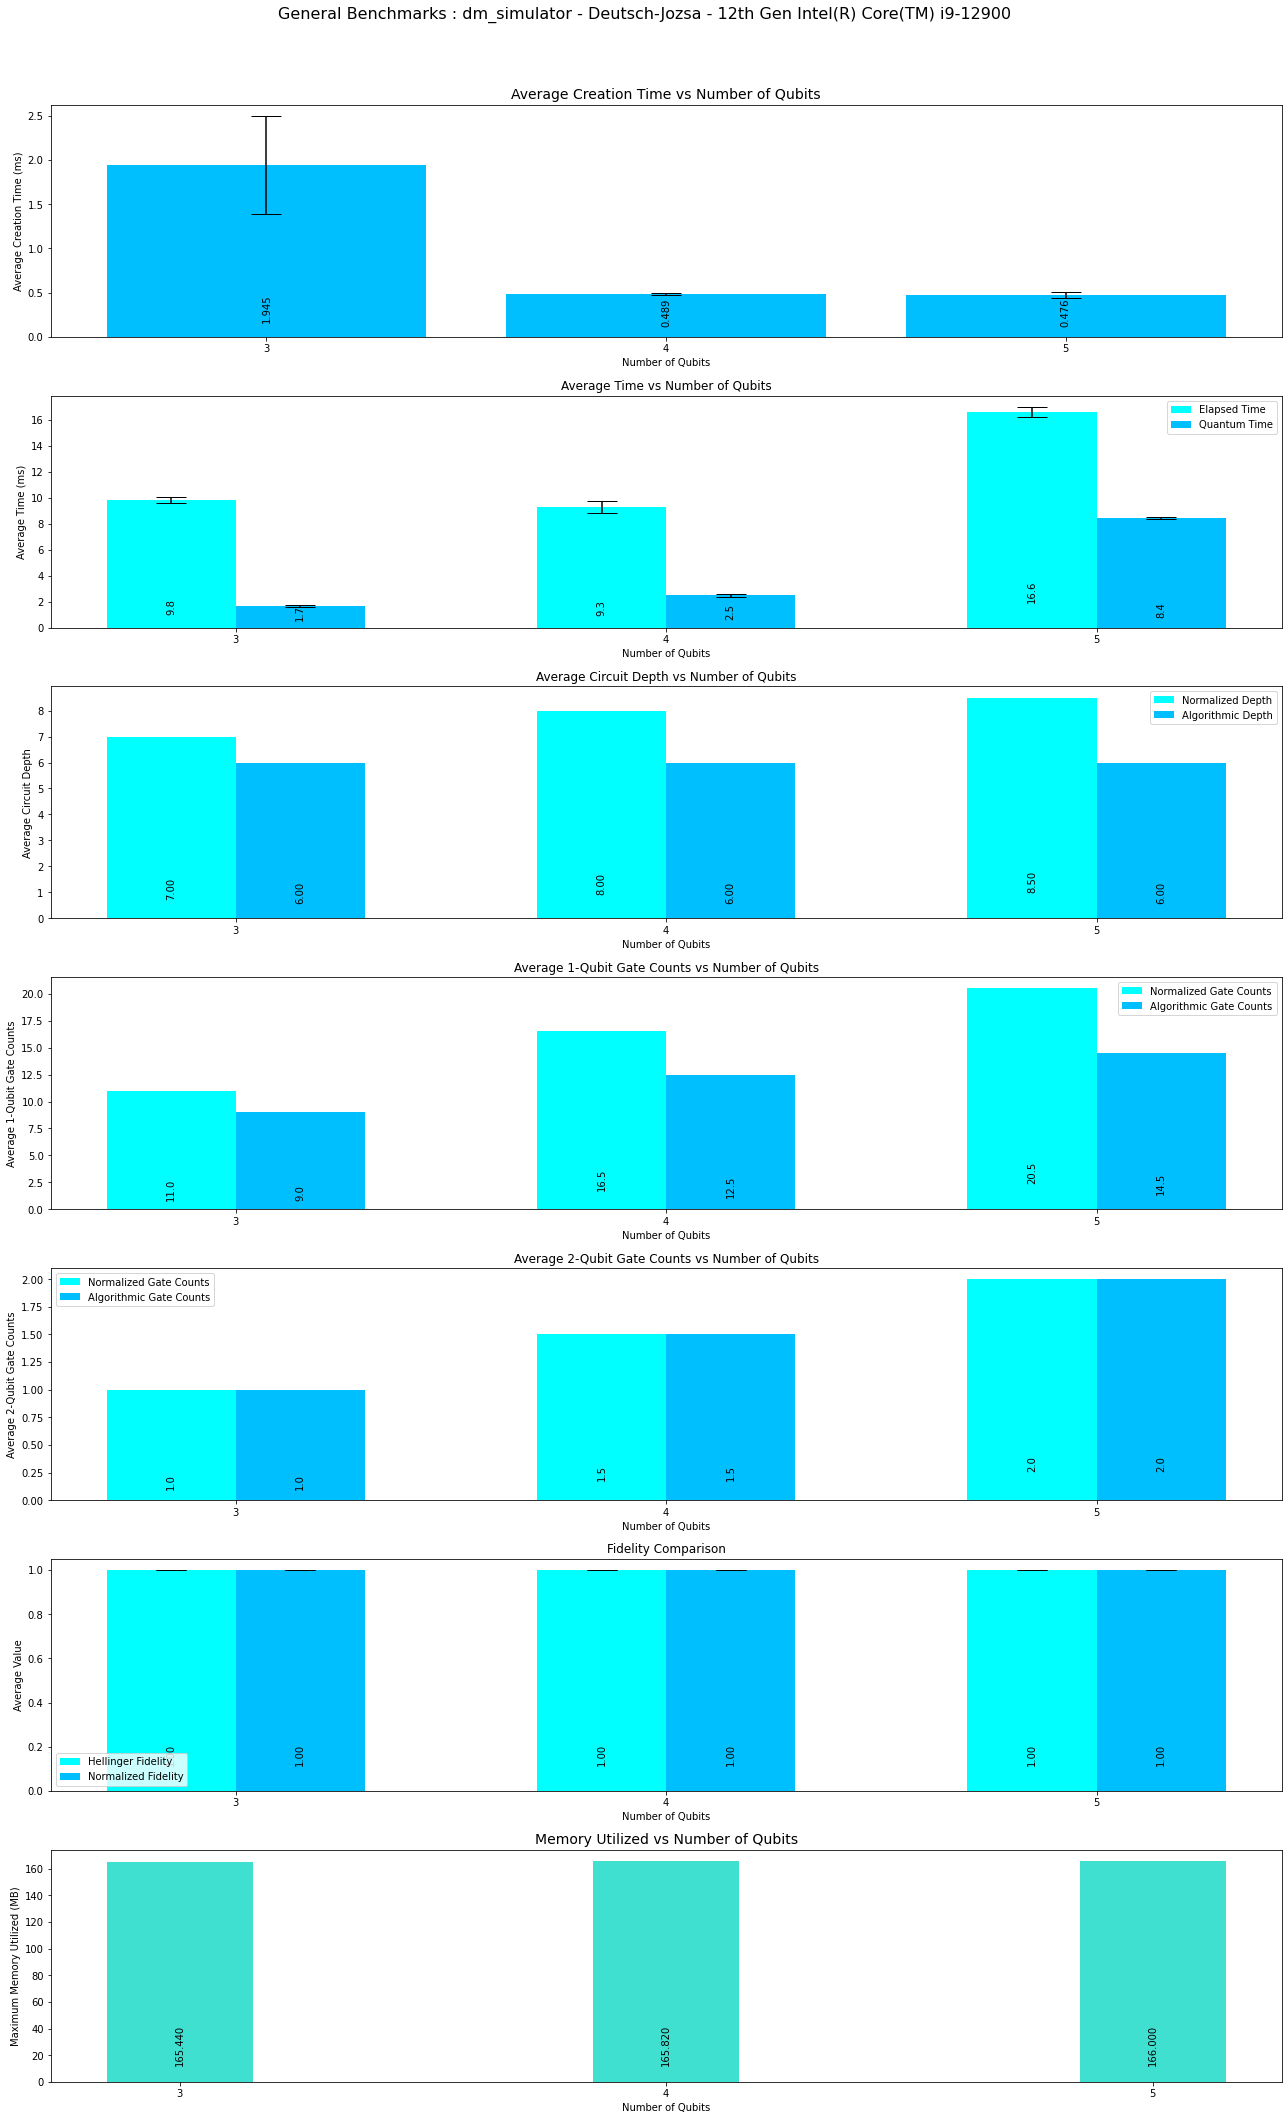

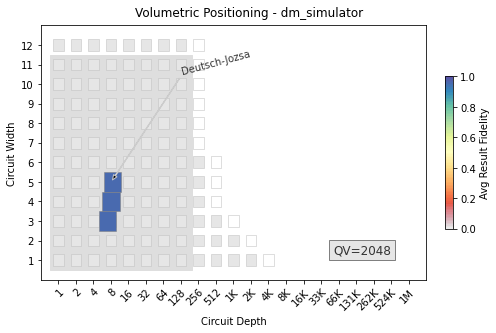

In [22]:
# Execute the benchmark program, accumulate metrics, and calculate circuit depths
(num_qubits_of_ckt, creation_times, elapsed_times, quantum_times, circuit_depths,transpiled_depths,xi, tr_xi, fidelity_data, Hf_fidelity_data, numckts,  
algorithmic_1Q_gate_counts, algorithmic_2Q_gate_counts, transpiled_1Q_gate_counts, transpiled_2Q_gate_counts,mem_usage) = run()

# Define the range of qubits for the x-axis
num_qubits_range = range(min_qbits, max_qbits+1,skp_qubits)
print("num_qubits_range =",num_qubits_range)

#Information of Execution Hardware
Processor,cores = get_cpu_info()
print(f"****** Completed Execution on processor {Processor} with {cores} cores ******")
# Calculate average creation time, elapsed time, quantum processing time, and circuit depth for each number of qubits
avg_creation_times = []
std_creation_times= []
avg_elapsed_times = []
std_elapsed_times= []
avg_quantum_times = []
std_quantum_times= []
avg_circuit_depths = []
avg_transpiled_depths = []
avg_1Q_algorithmic_gate_counts = []
avg_2Q_algorithmic_gate_counts = []
avg_1Q_Transpiled_gate_counts = []
avg_2Q_Transpiled_gate_counts = []
avg_xi=[]
avg_tr_xi=[]
max_memory = []
Qubits = []

start = 0
for num in numckts:
    avg_creation_times.append(round(np.mean(creation_times[start:start+num]),3))
    std_creation_times.append(round(np.std(creation_times[start:start+num])/np.sqrt(len(creation_times)), 3))
    avg_elapsed_times.append(round(np.mean(elapsed_times[start:start+num]),3))
    std_elapsed_times.append(round(np.std(elapsed_times[start:start+num])/np.sqrt(len(elapsed_times)), 3))
    avg_quantum_times.append(round(np.mean(quantum_times[start:start+num]),3))
    std_quantum_times.append(round(np.std(quantum_times[start:start+num])/np.sqrt(len(quantum_times)), 3))
    avg_circuit_depths.append(round(np.mean(circuit_depths[start:start+num]),3))
    avg_transpiled_depths.append(round(np.mean(transpiled_depths[start:start+num]),3))
    if gate_counts_plots == True:
        avg_1Q_algorithmic_gate_counts.append(round(np.mean(algorithmic_1Q_gate_counts[start:start+num]),2))
        avg_2Q_algorithmic_gate_counts.append(round(np.mean(algorithmic_2Q_gate_counts[start:start+num]),2))
        avg_xi.append(round(np.mean(xi[start:start+num]),2))
        avg_1Q_Transpiled_gate_counts.append(round(np.mean(transpiled_1Q_gate_counts[start:start+num]),2))
        avg_2Q_Transpiled_gate_counts.append(round(np.mean(transpiled_2Q_gate_counts[start:start+num]),2))
        avg_tr_xi.append(round(np.mean(tr_xi[start:start+num]),2))
    if Memory_utilization_plot == True:max_memory.append(round(np.max(mem_usage[start:start+num]),2))
    Qubits.append(int(np.mean(num_qubits_of_ckt[start:start+num])))
    start += num


# Calculate the fidelity data
avg_f, avg_Hf, std_f, std_hf = plot_fidelity_data(fidelity_data, Hf_fidelity_data, "Fidelity Comparison")

if Store_Data:
    import json
    from datetime import datetime
    # Prepare the data dictionary
    data = {
        "configuration":{
        "min_qbits":min_qbits,
        "max_qbits":max_qbits,
        "skp_qubits":skp_qubits,
        "num_ckts":numckts,
        "Type_of_Simulator":platform,
        "benchmark_name":benchmark_name,
        "QV_":QV_,
        "Processor":Processor,
        "cores":cores},
        'Number of Qubits': Qubits,
        "avg_creation_times (ms)": avg_creation_times,
        "std_creation_times (ms)": std_creation_times,
        "avg_elapsed_times (ms)": avg_elapsed_times,
        "std_elapsed_times (ms)":std_elapsed_times,
        "avg_quantum_times (ms)": avg_quantum_times,
        "std_quantum_times (ms)":std_quantum_times,
        "avg_circuit_depths": avg_circuit_depths,
        "avg_transpiled_depths": avg_transpiled_depths,
        "Average_Rescaled_fidelity":avg_f,
        "Average_Hellinger_fidelity":avg_Hf,
        "std_Rescaled_Fidelity":std_f,
        "std_hellinger_fidelity":std_hf
    }

    if gate_counts_plots:
        data["gate_counts_plots"] =  gate_counts_plots
        data["avg_1Q_algorithmic_gate_counts"] =  avg_1Q_algorithmic_gate_counts
        data["avg_2Q_algorithmic_gate_counts"] =  avg_2Q_algorithmic_gate_counts
        data["avg_xi (n2q/n1q+n2q)"]=avg_xi
        data["avg_1Q_Transpiled_gate_counts"]= avg_1Q_Transpiled_gate_counts
        data["avg_2Q_Transpiled_gate_counts"]= avg_2Q_Transpiled_gate_counts
        data["avg_tr_xi (tr_n2q/tr_n1q+tr_n2q)"]=avg_tr_xi

    if Memory_utilization_plot:
        data["max_memory (MB)"]= max_memory
    
    # Get the current date and time
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    # Add the timestamp to the data
    data['last_updated'] = current_time
    
    # Define the file name
    file_name = '__data.json'
    
    # Write the data to the file
    with open(file_name, 'w') as file:
        json.dump(data, file, indent=4)

    
    print(f"***** Data has been saved to {file_name} ******")

    if save_to_excel: 
        #from Data_Plotter import update_excel_with_data
        update_excel_with_data(f"{benchmark_name} Benchmark-Results.xlsx",data,Noise_Inclusion)
        print("***** Data has been updated to Benchmark-Results.xlsx *****")


# Plot histograms for average creation time, average elapsed time, average quantum processing time, and average circuit depth versus the number of qubits

# Add labels to the bars
def autolabel(rects,ax,str='{:.3f}',text_color="black"):
        max_y_value=ax.get_ylim()[1]  # Get the maximum value on the y-axis
        threshold=0.3*max_y_value   # Define threshold as 30% of max y-axis value
        for rect in rects:
            height = rect.get_height()
            if height < threshold:
                rotation = 90
                va = 'bottom'  # Place text above the bar
                xytext = (0, 3)  # Offset slightly above the bar
            else:
                rotation = 90
                va = 'center'  # Place text inside the bar
                xytext = (0, 0)  # No offset
            ax.annotate(str.format(height),  # Formatting to two decimal places
                        xy=(rect.get_x() + rect.get_width() / 2, height/6),
                        xytext=xytext,
                        textcoords="offset points",
                        ha='center', va=va, color=text_color, rotation=rotation)

bar_width = 0.3

# Determine the number of subplots and their arrangement
if Memory_utilization_plot and gate_counts_plots:
    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, 1, figsize=(18, 30))
    # Plotting for both memory utilization and gate counts
    # ax1, ax2, ax3, ax4, ax5, ax6, ax7 are available
elif Memory_utilization_plot:
    fig, (ax1, ax2, ax3, ax6, ax7) = plt.subplots(5, 1, figsize=(18, 30))
    # Plotting for memory utilization only
    # ax1, ax2, ax3, ax6, ax7 are available
elif gate_counts_plots:
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(18, 30))
    # Plotting for gate counts only
    # ax1, ax2, ax3, ax4, ax5, ax6 are available
else:
    fig, (ax1, ax2, ax3, ax6) = plt.subplots(4, 1, figsize=(18, 30))
    # Default plotting
    # ax1, ax2, ax3, ax6 are available

fig.suptitle(f"General Benchmarks : {platform} - {benchmark_name} - {Processor}", fontsize=16)


ax1.set_xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
x = ax1.bar(num_qubits_range, avg_creation_times, yerr=std_creation_times, capsize=15, color='deepskyblue')
autolabel(ax1.patches, ax1)
ax1.set_xlabel('Number of Qubits')
ax1.set_ylabel('Average Creation Time (ms)')
ax1.set_title('Average Creation Time vs Number of Qubits',fontsize=14)


ax2.set_xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))


Elapsed= ax2.bar(np.array(num_qubits_range) - bar_width / 2, avg_elapsed_times,yerr=std_elapsed_times, capsize=15, width=bar_width, color='cyan', label='Elapsed Time')
Quantum= ax2.bar(np.array(num_qubits_range) + bar_width / 2, avg_quantum_times,yerr=std_quantum_times, capsize=15,width=bar_width, color='deepskyblue',label ='Quantum Time')
autolabel(Elapsed,ax2,str='{:.1f}')
autolabel(Quantum,ax2,str='{:.1f}')
ax2.set_xlabel('Number of Qubits')
ax2.set_ylabel('Average Time (ms)')
ax2.set_title('Average Time vs Number of Qubits')
ax2.legend()


ax3.set_xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
Normalized = ax3.bar(np.array(num_qubits_range) - bar_width / 2, avg_transpiled_depths, color='cyan', label='Normalized Depth', width=bar_width)  # Adjust width here
Algorithmic = ax3.bar(np.array(num_qubits_range) + bar_width / 2,avg_circuit_depths, color='deepskyblue', label='Algorithmic Depth', width=bar_width)  # Adjust width here
autolabel(Normalized,ax3,str='{:.2f}')
autolabel(Algorithmic,ax3,str='{:.2f}')
ax3.set_xlabel('Number of Qubits')
ax3.set_ylabel('Average Circuit Depth')
ax3.set_title('Average Circuit Depth vs Number of Qubits')
ax3.legend()

if gate_counts_plots == True:
    ax4.set_xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
    Normalized_1Q_counts = ax4.bar(np.array(num_qubits_range) - bar_width / 2, avg_1Q_Transpiled_gate_counts, color='cyan', label='Normalized Gate Counts', width=bar_width)  # Adjust width here
    Algorithmic_1Q_counts = ax4.bar(np.array(num_qubits_range) + bar_width / 2, avg_1Q_algorithmic_gate_counts, color='deepskyblue', label='Algorithmic Gate Counts', width=bar_width)  # Adjust width here
    autolabel(Normalized_1Q_counts,ax4,str='{}')
    autolabel(Algorithmic_1Q_counts,ax4,str='{}')
    ax4.set_xlabel('Number of Qubits')
    ax4.set_ylabel('Average 1-Qubit Gate Counts')
    ax4.set_title('Average 1-Qubit Gate Counts vs Number of Qubits')
    ax4.legend()
    
    ax5.set_xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
    Normalized_2Q_counts = ax5.bar(np.array(num_qubits_range) - bar_width / 2, avg_2Q_Transpiled_gate_counts, color='cyan', label='Normalized Gate Counts', width=bar_width)  # Adjust width here
    Algorithmic_2Q_counts = ax5.bar(np.array(num_qubits_range) + bar_width / 2, avg_2Q_algorithmic_gate_counts, color='deepskyblue', label='Algorithmic Gate Counts', width=bar_width)  # Adjust width here
    autolabel(Normalized_2Q_counts,ax5,str='{}')
    autolabel(Algorithmic_2Q_counts,ax5,str='{}')
    ax5.set_xlabel('Number of Qubits')
    ax5.set_ylabel('Average 2-Qubit Gate Counts')
    ax5.set_title('Average 2-Qubit Gate Counts vs Number of Qubits')
    ax5.legend()


ax6.set_xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
Hellinger = ax6.bar(np.array(num_qubits_range) - bar_width / 2, avg_Hf,yerr=std_hf, capsize=15, width=bar_width, label='Hellinger Fidelity',color='cyan')  # Adjust width here
Normalized = ax6.bar(np.array(num_qubits_range) + bar_width / 2, avg_f,yerr=std_f, capsize=15, width=bar_width, label='Normalized Fidelity', color='deepskyblue')  # Adjust width here
autolabel(Hellinger,ax6,str='{:.2f}')
autolabel(Normalized,ax6,str='{:.2f}')
ax6.set_xlabel('Number of Qubits')
ax6.set_ylabel('Average Value')
ax6.set_title("Fidelity Comparison")
ax6.legend()

if Memory_utilization_plot == True:
    ax7.set_xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
    x = ax7.bar(num_qubits_range, max_memory, color='turquoise', width=bar_width, label="Memory Utilizations")
    autolabel(ax7.patches, ax7)
    ax7.set_xlabel('Number of Qubits')
    ax7.set_ylabel('Maximum Memory Utilized (MB)')
    ax7.set_title('Memory Utilized vs Number of Qubits',fontsize=14)


plt.tight_layout(rect=[0, 0, 1, 0.96])
if saveplots == True:
    plt.savefig("ParameterPlotsSample.jpg")
plt.show()

num_qubits_range = Qubits

# Quantum Volume Plot
Suptitle = f"Volumetric Positioning - {platform}"
appname=benchmark_name
if QV_ == None:
    QV=2048
else:
    QV=QV_
depth_base =2

ax = plot_volumetric_background(max_qubits=max_qbits, QV=QV,depth_base=depth_base, suptitle=Suptitle, colorbar_label="Avg Result Fidelity")

w_data = num_qubits_range
# determine width for circuit
w_max = 0
for i in range(len(w_data)):
    y = float(w_data[i])
    w_max = max(w_max, y)

d_tr_data = avg_transpiled_depths
f_data = avg_f

plot_volumetric_data(ax, w_data, d_tr_data, f_data, depth_base, fill=True,label=appname, labelpos=(0.4, 0.6), labelrot=15, type=1, w_max=w_max)
anno_volumetric_data(ax, depth_base,label=appname, labelpos=(0.4, 0.6), labelrot=15, type=1, fill=False)